In [9]:
import numpy as np
from air.datasets.classical_exp import hammer_electric_dataset_double_traj


DEVICE = 'cuda'


# No magnetic field

In [65]:
from air.datasets.classical_exp import create_traj
import math

In [83]:

key = jax.random.PRNGKey(2)
        
# Hammer action
trajs_h = create_traj(key,
                    times, 
                        alpha_1 = 1., 
                        alpha_2 = 0, 
                        alpha_ext = 0, 
                        num_samples = math.ceil(100/2))

In [96]:
dataset_size = int(1e4) #len(model.dls.train_ds) + len(model.dls.valid_ds)
size_train = 0.8
epochs = 200
BS = 50

dim_actions = 2
dim_z = 2
lr, beta = (1e-4, 0.001)

times = np.linspace(0.,2,200)

min_mass = 0.4
max_mass = 1.75
min_charge = -1.7
max_charge = -0.5

import torch
torch.manual_seed(0)
data, loader_test, loader = hammer_electric_dataset_double_traj(dataset_size = dataset_size,
                                                                size_train= size_train,
                                                                BS = BS,
                                                                key_jax = 12,
                                                                times = times,   
                                                                act_rep_val = 1,
                                                                alpha_ext = 0,
                                                                min_mass = min_mass,
                                                                max_mass = max_mass,
                                                                min_charge = min_charge,
                                                                max_charge = max_charge
                                                                )


In [97]:
import torch
torch.manual_seed(12)
AE = VAIR(dim_x = 2*times.shape[0]*2, # Dimension input to encoder
              dim_z = dim_z, # Dimension latent
              dim_a = dim_actions, # Dimension action representation               
              dim_y = times.shape[0]*2,
       ).to(DEVICE)




learn = Learner(data, 
              AE,
              loss_func = beta_mse_loss(loss_objective = 'H',
                                          beta = beta,
                                          recon_objective='mse'), 
              opt_func= Adam,
              cbs = (
                     save_logvars(),
                     save_separate_losses(loader)
                     )     
              )


with learn.no_logging(): learn.fit(epochs, lr = lr)

Text(0.5, 1.0, 'KL loss')

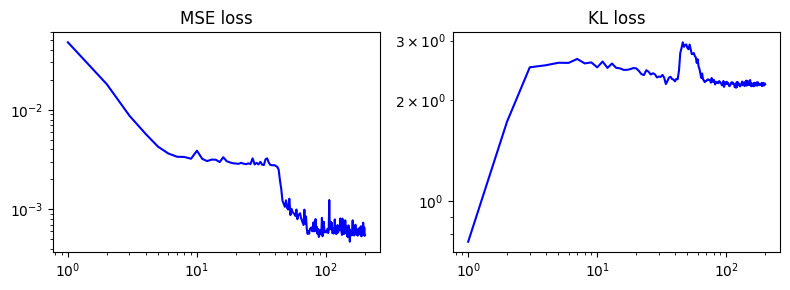

In [98]:
fig, ax = plt.subplots(1, 2, figsize = (8,3), tight_layout = True)

ax[0].loglog(torch.arange(1,2+learn.epoch), learn.save_separate_losses.mse_loss, c = 'b', zorder = 100)
ax[0].set_title('MSE loss')

ax[1].loglog(torch.arange(1,2+learn.epoch), np.array(learn.save_separate_losses.kl_loss)/learn.loss_func.beta, c = 'b', zorder = 100)
ax[1].set_title('KL loss')


# ax[0].axhline(1e-6, ls = '--', c = 'k', alpha = 0.5)

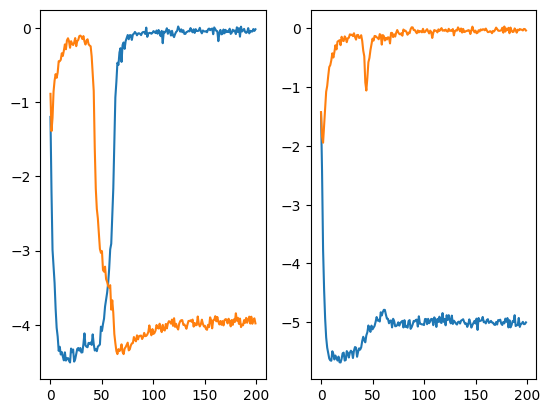

In [99]:
fig, ax = plt.subplots(1,2)

for idx in range(2):
    ax[idx].plot(learn.save_logvars.logvars[:,idx].detach().cpu());

In [94]:
from air.datasets.classical_exp import create_traj_mass, create_traj_charge
import jax
import jax.numpy as jnp

Text(0.5, 0, 'z1 (mus_q)')

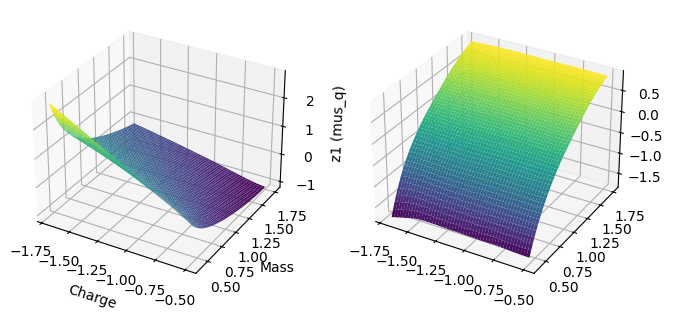

In [100]:
num_trajs = 50


charges = np.linspace(min_charge, max_charge, num_trajs)
masses = np.linspace(min_mass, max_mass, num_trajs)

charges_grid, masses_grid = np.meshgrid(charges, masses)
charges_comb = charges_grid.ravel()
masses_comb = masses_grid.ravel()

trajs_h = create_traj_mass(None,
                            times,
                            masses_comb).reshape(-1,int(2*times.shape[0]))

trajs_e = create_traj_charge(jax.random.PRNGKey(1), 
                                            times,
                                            masses = masses_comb,
                                            charges = charges_comb,
                                            ).reshape(-1,int(2*times.shape[0]))


# trajs_m = (jax.vmap(create_traj_magnetic, in_axes=(0,0,None))(masses_comb, charges_comb, times)).reshape(-1,int(2*times.shape[0]))

# trajs_h += trajs_m
# trajs_e += trajs_m


trajs_e = trajs_e.reshape(num_trajs**2, jnp.size(times)*2)
trajs_h = trajs_h.reshape(num_trajs**2, jnp.size(times)*2)

input_trajs = torch.tensor(np.concatenate([trajs_h, trajs_e], axis=1))

mus_q = learn.encoder(input_trajs.to(DEVICE)).detach().cpu()

mus_q_grid = mus_q.reshape(num_trajs, num_trajs, -1)

# Example: plot z1 as a function of charges and masses
# plt.figure(figsize=(7, 5))
# plt.contourf(charges_grid, masses_grid, mus_q_grid[:, :, 1].numpy(), levels=30, cmap='viridis')
# plt.xlabel('Charge')
# plt.ylabel('Mass')
# plt.title('z1 (mus_q) as function of charge and mass')
# plt.colorbar(label='z1 (mus_q)')

fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(121, projection='3d')
ax.plot_surface(charges_grid, masses_grid, mus_q_grid[:, :, 0].numpy(), cmap='viridis')

ax2 = fig.add_subplot(122, projection='3d')
ax2.plot_surface(charges_grid, masses_grid, mus_q_grid[:, :, 1].numpy(), cmap='viridis')


ax.set_xlabel('Charge')
ax.set_ylabel('Mass')
ax.set_zlabel('z1 (mus_q)')
# plt.setp([ax,ax2], zlim = (-2,2))
